In [ ]:
import pandas as pd
import os

dataset_path = '/kaggle/input/new-plant-diseases-dataset/'

# Explore the directory structure
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.utils import class_weight
import shutil
import time
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, optimizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
import os

# Chemin de base
base_path = '/kaggle/input/new-plant-diseases-dataset/'

# Chercher les dossiers train, valid, test
def find_data_dirs(base_path):
    train_dir = None
    valid_dir = None
    test_dir = None
    
    # Parcourir tous les sous-dossiers
    for root, dirs, files in os.walk(base_path):
        for d in dirs:
            if 'train' in d.lower():
                train_dir = os.path.join(root, d)
            elif 'valid' in d.lower() or 'val' in d.lower():
                valid_dir = os.path.join(root, d)
            elif 'test' in d.lower():
                test_dir = os.path.join(root, d)
    
    return train_dir, valid_dir, test_dir

# Trouver les dossiers automatiquement
train_dir, valid_dir, test_dir = find_data_dirs(base_path)

print(f"Train directory: {train_dir}")
print(f"Valid directory: {valid_dir}")
print(f"Test directory: {test_dir}")

In [ ]:

# Vérifier que les dossiers existent
import os
print("Vérification des dossiers:")
print(f"Train dir exists: {os.path.exists(train_dir)}")
print(f"Valid dir exists: {os.path.exists(valid_dir)}")
print(f"Test dir exists: {os.path.exists(test_dir)}")

In [ ]:
nums = {}
for dir_name in sorted(os.listdir(train_dir)):
    class_dir = os.path.join(train_dir, dir_name)
    if os.path.isdir(class_dir):
        nums[dir_name] = len(os.listdir(class_dir))
# Total number of images
n_train = sum(nums.values())
print(f"There are {n_train} images for training")
# Convert to DataFrame and sort index
img_per_class = pd.DataFrame.from_dict(nums, orient='index', columns=["no. of images"])
img_per_class.index.name = "class name"
img_per_class = img_per_class.sort_index()
img_per_class

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # flip horizontal
    tf.keras.layers.RandomRotation(0.2), # rotated by a random amount between -20% and +20% of a full circle
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), # zoom in/out by up to 20%
    tf.keras.layers.RandomContrast(factor=0.2) # Adjust contrast by up to 20%
])

# ResNet-50

In [7]:
import tensorflow as tf

print("GPU disponible :", tf.config.list_physical_devices('GPU'))
!nvidia-smi

GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Sep 10 14:49:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             31W /  250W |     259MiB /  16384MiB |      0%      Default |
|                                         |             

In [8]:
import tensorflow as tf

weights_path = "/kaggle/input/resnet50/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# =========================
# 1) Lister fichiers + labels (depuis TRAIN_DIR)
# =========================
import os, pathlib, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf

SEED = 123
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_DIR = "/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train"

# Collecte de tous les fichiers avec leur label (nom du dossier parent)
rows = []
for class_dir in sorted(os.listdir(TRAIN_DIR)):
    cpath = os.path.join(TRAIN_DIR, class_dir)
    if not os.path.isdir(cpath):
        continue
    for fp in pathlib.Path(cpath).glob("*"):
        if fp.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            rows.append({"filepath": str(fp), "label": class_dir})

df = pd.DataFrame(rows)
print(f"Total images (train source): {len(df)} | Classes: {df['label'].nunique()}")

# Classes triées et mapping label->index (à réutiliser partout)
class_names = sorted(df["label"].unique().tolist())
name_to_idx = {name: i for i, name in enumerate(class_names)}
df["y"] = df["label"].map(name_to_idx)

# =========================
# 2) Split stratifié: train/val/test = 80/10/10
# =========================
# d’abord train_temp / test (10%)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED)
train_temp_idx, test_idx = next(sss1.split(df["filepath"], df["y"]))
df_train_temp = df.iloc[train_temp_idx].reset_index(drop=True)
df_test       = df.iloc[test_idx].reset_index(drop=True)

# puis train / val (12.5% de train_temp ≈ 0.125 * 0.90 = 0.1125 ~ 10% du total)
val_fraction_in_temp = 0.125
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction_in_temp, random_state=SEED)
train_idx, val_idx = next(sss2.split(df_train_temp["filepath"], df_train_temp["y"]))
df_train = df_train_temp.iloc[train_idx].reset_index(drop=True)
df_val   = df_train_temp.iloc[val_idx].reset_index(drop=True)

print(f"Split -> train: {len(df_train)} | val: {len(df_val)} | test: {len(df_test)}")

# =========================
# 3) Fonctions utilitaires pour tf.data
# =========================
def make_ds(filepaths, labels, img_size=IMG_SIZE, batch_size=BATCH_SIZE, training=False):
    paths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    def load_and_preprocess(path, y):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32)
        img = tf.keras.applications.resnet.preprocess_input(img)
        return img, y

    ds = tf.data.Dataset.zip((paths_ds, labels_ds))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(buffer_size=8 * batch_size, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds_new = make_ds(df_train["filepath"].values, df_train["y"].values, training=True)
val_ds_new   = make_ds(df_val["filepath"].values,   df_val["y"].values,   training=False)
test_ds_new  = make_ds(df_test["filepath"].values,  df_test["y"].values,  training=False)

print("Datasets prêts. Exemple shapes:")
for imgs, ys in train_ds_new.take(1):
    print("train batch:", imgs.shape, ys.shape)

# Pour info : class_names est le vocabulaire à réutiliser
print("Nombre de classes:", len(class_names))

Total images (train source): 70295 | Classes: 38
Split -> train: 55356 | val: 7909 | test: 7030
Datasets prêts. Exemple shapes:
train batch: (32, 224, 224, 3) (32,)
Nombre de classes: 38


# resnet avec learning rate = 0.00001

In [ ]:
from tensorflow.keras.applications import ResNet50
from keras.callbacks import EarlyStopping

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=weights_path,      # on pointe vers le fichier uploadé
    input_shape=(224, 224, 3)
)
base_model.trainable = False
base_model.trainable = False

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True
    inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(38)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(patience=3)

# Train the model with early stopping
history = model.fit(
    train_ds_new,
    validation_data=val_ds_new,
    epochs=10,
    callbacks=[early_stopping],     # EarlyStopping, ModelCheckpoint, etc.
    class_weight=None    # (optionnel) recalculer avec df_train['y'] si classes déséquilibrées
)

# resnet avec learning rate = 0.001

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import callbacks

# Base ResNet50
base_model = ResNet50(
    include_top=False,
    weights=weights_path,   # chemin vers tes poids
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Débloquer les 10 dernières couches pour fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Construction du modèle
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(38, activation='softmax')(x)  # softmax pour classification multi-classes

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # car softmax activé
    metrics=['accuracy']
)

# Callbacks : EarlyStopping + sauvegarde du meilleur modèle
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,                # plus de tolérance
    min_delta=0.001,            # ignore les petites fluctuations
    restore_best_weights=True   # remet les meilleurs poids
)

checkpoint = callbacks.ModelCheckpoint(
    filepath="best_resnet50_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

# Entraînement
history = model.fit(
    train_ds_new,
    validation_data=val_ds_new,
    epochs=10,                   # ✅ autoriser plus d’époques
    callbacks=[early_stopping, checkpoint],
    class_weight=None
)


Epoch 1/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 195s 105ms/step - accuracy: 0.6094 - loss: 1.3759 - val_accuracy: 0.7400 - val_loss: 1.0625
Epoch 2/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 178s 103ms/step - accuracy: 0.8138 - loss: 0.6064 - val_accuracy: 0.6782 - val_loss: 1.5375
Epoch 3/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 177s 102ms/step - accuracy: 0.8433 - loss: 0.5065 - val_accuracy: 0.6785 - val_loss: 1.5790
Epoch 4/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 179s 103ms/step - accuracy: 0.8596 - loss: 0.4507 - val_accuracy: 0.7010 - val_loss: 1.7655
Epoch 5/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 178s 103ms/step - accuracy: 0.8694 - loss: 0.4156 - val_accuracy: 0.7160 - val_loss: 1.7681
Epoch 6/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 177s 102ms/step - accuracy: 0.8797 - loss: 0.3848 - val_accuracy: 0.7531 - val_loss: 1.2279
Epoch 7/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 178s 103ms/step - accuracy: 0.8851 - loss: 0.3665 - val_accuracy: 0.7467 - val_loss: 1.3457
Epoch 8/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 178s 103ms/step - ac

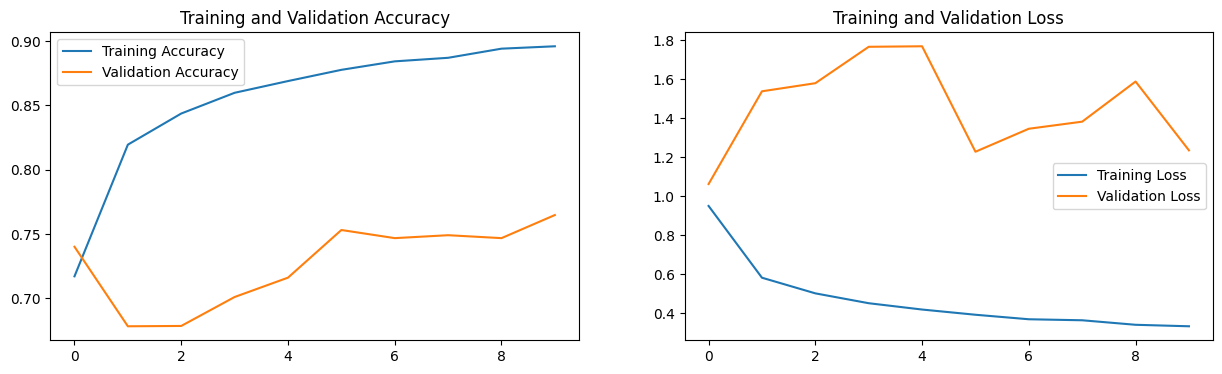

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

248/248 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step


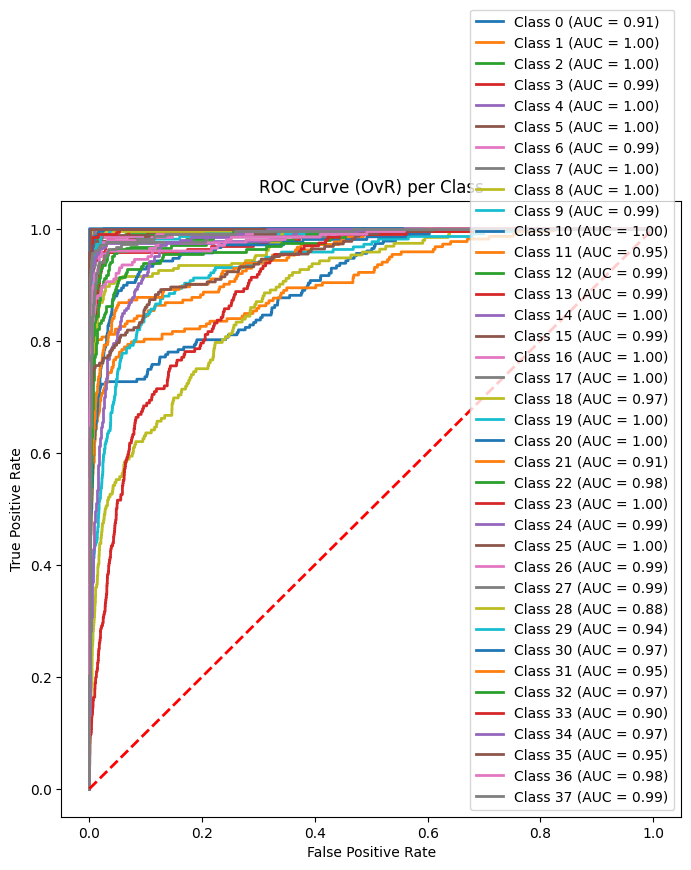

ROC-AUC Score (OvR, Validation) : 0.9771677201429108


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# -----------------------------
# 1️⃣ Extraire les images et labels du dataset de validation
# -----------------------------
X_val_list, y_val_list = [], []

for images, labels in val_ds_new:
    X_val_list.append(images.numpy())
    y_val_list.append(labels.numpy())

X_val = np.concatenate(X_val_list, axis=0)
y_val_int = np.concatenate(y_val_list, axis=0)  # labels entiers

# Convertir en one-hot
n_classes = len(np.unique(y_val_int))
y_val = to_categorical(y_val_int, num_classes=n_classes)

# -----------------------------
# 2️⃣ Prédictions du modèle
# -----------------------------
y_pred = tf.nn.softmax(model.predict(X_val)).numpy()  # shape (N, n_classes)

# -----------------------------
# 3️⃣ ROC Curve One-vs-Rest pour chaque classe
# -----------------------------
plt.figure(figsize=(8,8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc_i:.2f})')

plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (OvR) per Class')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# 4️⃣ Score ROC-AUC global (OvR)
# -----------------------------
from sklearn.metrics import roc_auc_score
roc_auc_global = roc_auc_score(y_val, y_pred, multi_class='ovr')
print("ROC-AUC Score (OvR, Validation) :", roc_auc_global)


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Predict on validation set
y_true = []
y_pred = []

for images, labels in val_ds_new:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print("📊 Validation Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print()

# Classification report
print("🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# test ResNet50

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

test_loss, test_acc = model.evaluate(test_ds_new, verbose=1)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")
y_true, y_pred = [], []
for images, labels in test_ds_new:
    logits = model.predict(images, verbose=0)
    preds = np.argmax(logits, axis=1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
print(f"\n📊 Test — Acc:{acc:.4f}  Prec:{prec:.4f}  Rec:{rec:.4f}  F1:{f1:.4f}\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Test"); plt.xlabel("Pred"); plt.ylabel("True")
plt.tight_layout(); plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Nombre de classes
n_classes = len(class_names)  

class_samples = {}
X_test_aug = []
true_labels_idx = []
true_labels_name = []

# -----------------------------
# 1️⃣ Sélectionner 1 image par classe depuis val_ds_new
# -----------------------------
for batch in val_ds_new:
    images, labels = batch
    labels_idx = labels.numpy() if len(labels.shape) == 1 else np.argmax(labels.numpy(), axis=1)

    for i, label in enumerate(labels_idx):
        if label not in class_samples:  # première image trouvée pour cette classe
            class_samples[label] = True
            X_test_aug.append(images[i].numpy())
            true_labels_idx.append(label)              # indice réel
            true_labels_name.append(class_names[label]) # nom réel
    if len(class_samples) == n_classes:
        break

X_test_aug = np.stack(X_test_aug, axis=0)
print("Images test simulées :", X_test_aug.shape)

# -----------------------------
# 2️⃣ Faire les prédictions
# -----------------------------
y_pred_proba = model.predict(X_test_aug, verbose=0)
pred_classes_idx = np.argmax(y_pred_proba, axis=1)
pred_classes_name = [class_names[i] for i in pred_classes_idx]

# -----------------------------
# 3️⃣ Créer le DataFrame final
# -----------------------------
df_pred = pd.DataFrame({
    "true_class_idx": true_labels_idx,
    "true_class": true_labels_name,
    "predicted_class_idx": pred_classes_idx,
    "predicted_class": pred_classes_name
})

# Sauvegarde CSV
output_csv = "predictions_test_simulated.csv"
df_pred.to_csv(output_csv, index=False)

print(f"CSV final généré : {output_csv}")
print(df_pred.head(38).to_markdown(index=False))


In [ ]:
import pandas as pd

# Charger ton CSV
df_pred = pd.read_csv("predictions_test_simulated.csv")

# Garder uniquement colonnes utiles
df_compare = df_pred[["true_class", "predicted_class"]]

# Affichage clair (markdown par exemple)
print(df_compare.head(20).to_markdown(index=False))


# MobileNet

In [51]:
# Build MobileNetV2 model with transfer learning
def build_mobilenet():
    # Load the pre-trained MobileNetV2 model
    base_model = MobileNetV2(
        input_shape=img_size + (3,),
        include_top=False,
        weights='/kaggle/input/mobilenet/keras/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the new model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),  # Increased units
        layers.BatchNormalization(),            # Batch normalization
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),  # Additional dense layer
        layers.BatchNormalization(),            # Batch normalization
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
    return model

# Create the model
mobilenet_model = build_mobilenet()

# Display model summary
mobilenet_model.summary()

# Callbacks
mobilenet_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

mobilenet_checkpoint = ModelCheckpoint(
   'mobilenet_model.keras',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
mobilenet_history = mobilenet_model.fit(
    train_ds_new,
    validation_data=val_ds_new,
    epochs=10,
    callbacks=[mobilenet_early_stop, mobilenet_checkpoint]
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,663,526 (10.16 MB)

 Trainable params: 404,518 (1.54 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

Epoch 1/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 100s 51ms/step - accuracy: 0.4370 - loss: 2.0735 - val_accuracy: 0.7646 - val_loss: 0.7247
Epoch 2/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 74s 43ms/step - accuracy: 0.6753 - loss: 1.0331 - val_accuracy: 0.7868 - val_loss: 0.6508
Epoch 3/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 74s 43ms/step - accuracy: 0.7134 - loss: 0.9118 - val_accuracy: 0.7959 - val_loss: 0.6128
Epoch 4/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - accuracy: 0.7294 - loss: 0.8434 - val_accuracy: 0.8115 - val_loss: 0.5807
Epoch 5/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - accuracy: 0.7451 - loss: 0.7965 - val_accuracy: 0.8280 - val_loss: 0.5350
Epoch 6/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.7570 - loss: 0.7584 - val_accuracy: 0.8270 - val_loss: 0.5136
Epoch 7/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 73s 42ms/step - accuracy: 0.7652 - loss: 0.7343 - val_accuracy: 0.8337 - val_loss: 0.5156
Epoch 8/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.7685 

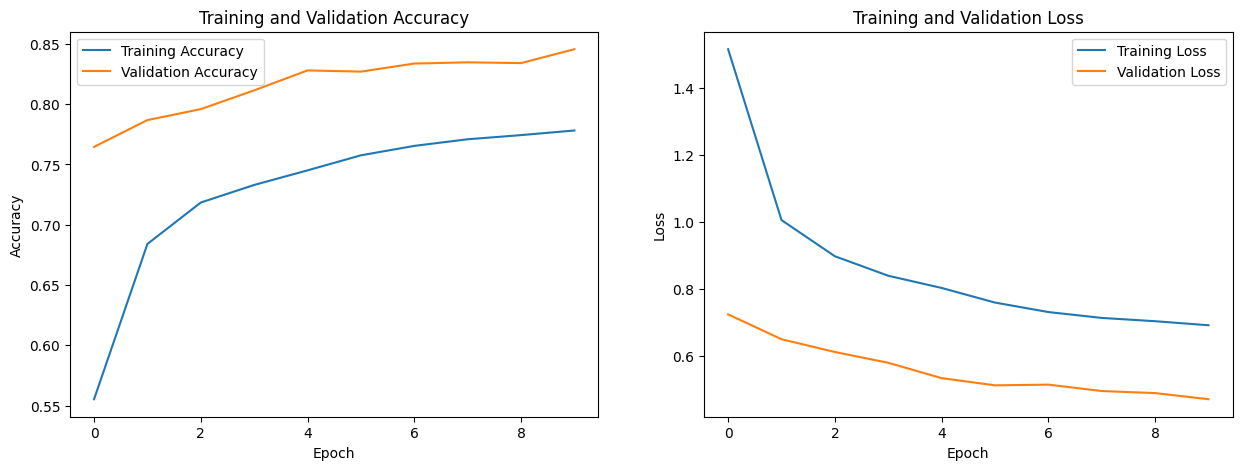

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

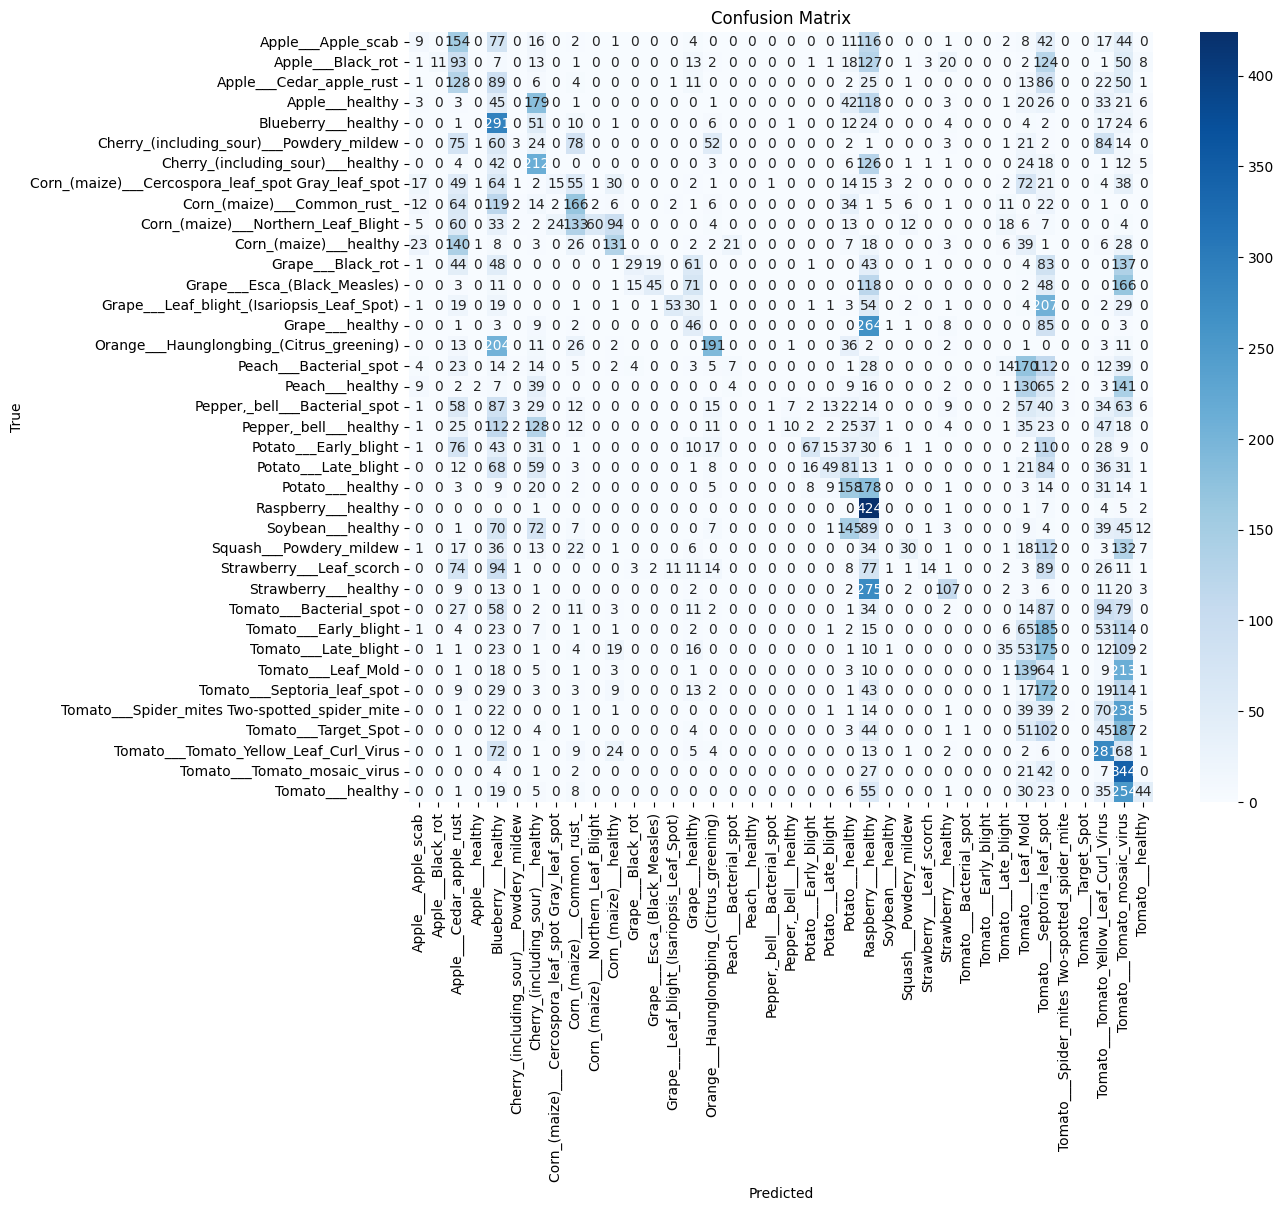

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.10      0.02      0.03       504
                                 Apple___Black_rot       0.92      0.02      0.04       497
                          Apple___Cedar_apple_rust       0.11      0.29      0.16       440
                                   Apple___healthy       0.00      0.00      0.00       502
                               Blueberry___healthy       0.15      0.64      0.24       454
          Cherry_(including_sour)___Powdery_mildew       0.19      0.01      0.01       421
                 Cherry_(including_sour)___healthy       0.22      0.46      0.30       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.37      0.04      0.07       410
                       Corn_(maize)___Common_rust_       0.27      0.35      0.31       477
               Corn_(maize)___Northern_Leaf_Blight     

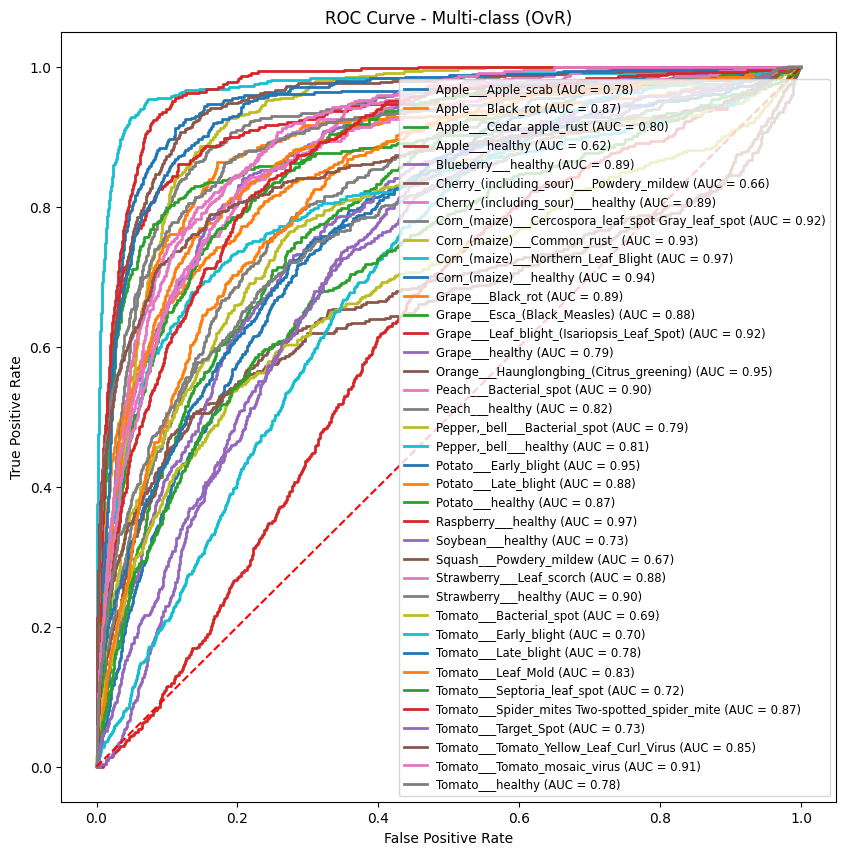

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
import tensorflow as tf

# -----------------------------
# 1️⃣ Courbes de Loss et Accuracy
# -----------------------------
acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# -----------------------------
# 2️⃣ Prédictions sur le validation set
# -----------------------------
y_val = []
y_pred = []

for batch_x, batch_y in val_ds_new:
    y_val.append(batch_y)
    preds = mobilenet_model.predict(batch_x)
    y_pred.append(preds)
    
    # Break the loop if generator is exhausted
    if len(y_val)*val_ds_new.batch_size >= val_ds_new.samples:
        break

y_val = np.vstack(y_val)
y_pred = np.vstack(y_pred)

# Classes vraies et prédictions
y_true_classes = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = list(train_ds_new.class_indices.keys())

# -----------------------------
# 3️⃣ Matrice de confusion
# -----------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# -----------------------------
# 4️⃣ Rapport de classification
# -----------------------------
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)

# -----------------------------
# 5️⃣ ROC-AUC Multi-classes (One-vs-Rest)
# -----------------------------
roc_auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
print(f"ROC-AUC Score (OvR, Validation): {roc_auc:.4f}")

# Optionnel : Courbes ROC pour chaque classe
plt.figure(figsize=(10,10))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class (OvR)')
plt.legend(loc='lower right', fontsize='small')
plt.show()


In [55]:
# Étape 1 : Préparer data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Étape 2 : Charger MobileNetV2 (weights ImageNet)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights="/kaggle/input/mobilenet/keras/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
)

base_model.trainable = False  # geler pour le warmup

# Étape 3 : Construire modèle
inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(train_generator.num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

# Étape 4 : Compiler
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Étape 5 : Calcul des poids de classes
from sklearn.utils import class_weight
import numpy as np

y_train = np.concatenate([y.numpy() for x, y in train_ds_new], axis=0)

# Calcul des poids de classes équilibrés
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Étape 6 : Entraînement (warmup)
history = model.fit(
    train_ds_new,
    validation_data=val_ds_new,
    epochs=10,
    class_weight=class_weights,
    callbacks=[mobilenet_early_stop, mobilenet_checkpoint]
)

# Étape 7 : Fine-tuning (débloquer dernier bloc de MobileNetV2)
base_model.trainable = True
for layer in base_model.layers[:-40]:  # on garde ~40 dernières couches dégelées
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_ds_new,
    validation_data=val_ds_new,
    epochs=10,
    class_weight=class_weights,
    callbacks=[mobilenet_early_stop, mobilenet_checkpoint]
)

Epoch 1/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 102s 54ms/step - accuracy: 0.6184 - loss: 1.3508 - val_accuracy: 0.6171 - val_loss: 1.3657
Epoch 2/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 91s 52ms/step - accuracy: 0.7897 - loss: 0.6655 - val_accuracy: 0.6170 - val_loss: 1.3519
Epoch 3/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 91s 52ms/step - accuracy: 0.8052 - loss: 0.6094 - val_accuracy: 0.6639 - val_loss: 1.2025
Epoch 4/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 91s 52ms/step - accuracy: 0.8135 - loss: 0.5784 - val_accuracy: 0.6823 - val_loss: 1.0846
Epoch 5/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 92s 53ms/step - accuracy: 0.8199 - loss: 0.5609 - val_accuracy: 0.6724 - val_loss: 1.1049
Epoch 6/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 91s 52ms/step - accuracy: 0.8259 - loss: 0.5384 - val_accuracy: 0.6580 - val_loss: 1.2089
Epoch 7/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 91s 52ms/step - accuracy: 0.8307 - loss: 0.5176 - val_accuracy: 0.6847 - val_loss: 1.1005
Epoch 8/10
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 91s 52ms/step - accuracy: 0.8335 

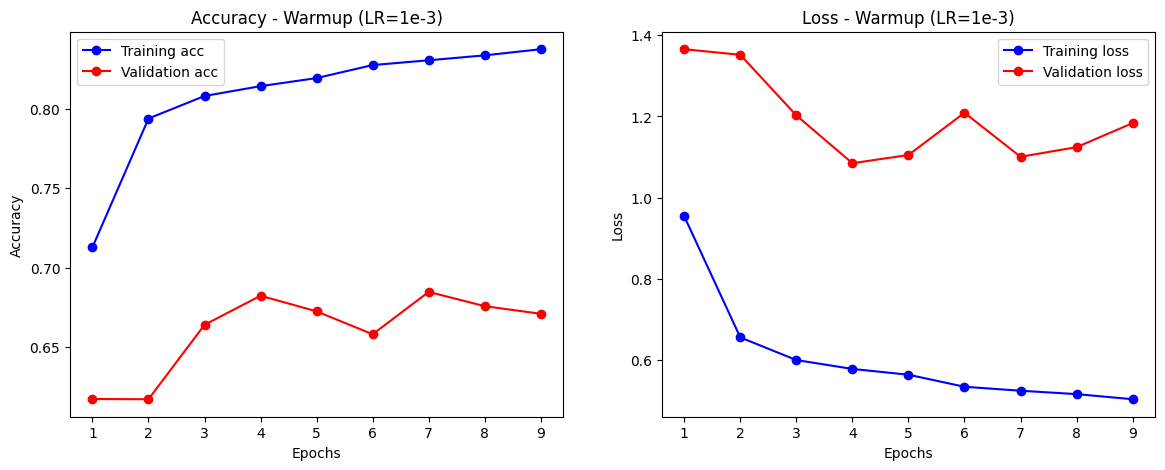

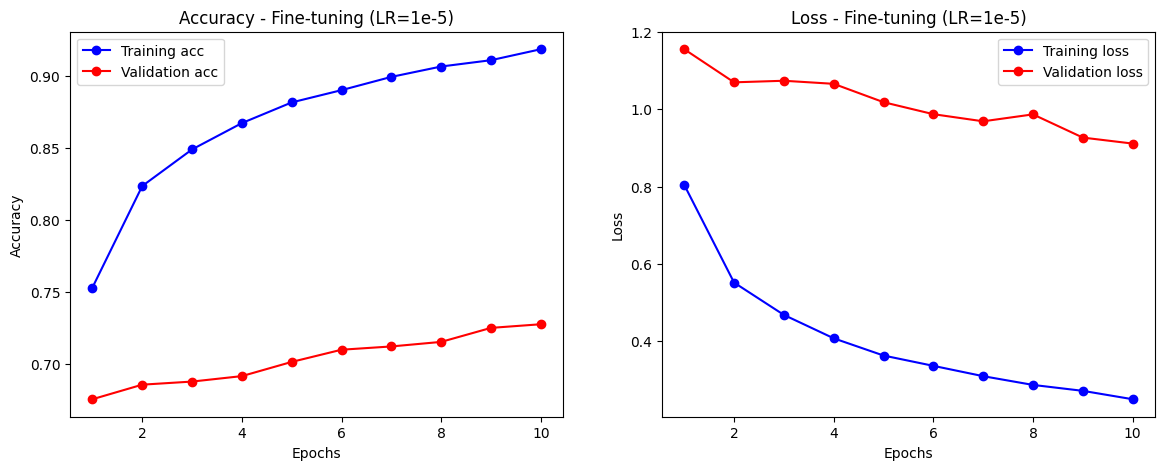

In [56]:
import matplotlib.pyplot as plt

def plot_training(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Visualiser les deux phases
plot_training(history, "Warmup (LR=1e-3)")
plot_training(fine_tune_history, "Fine-tuning (LR=1e-5)")

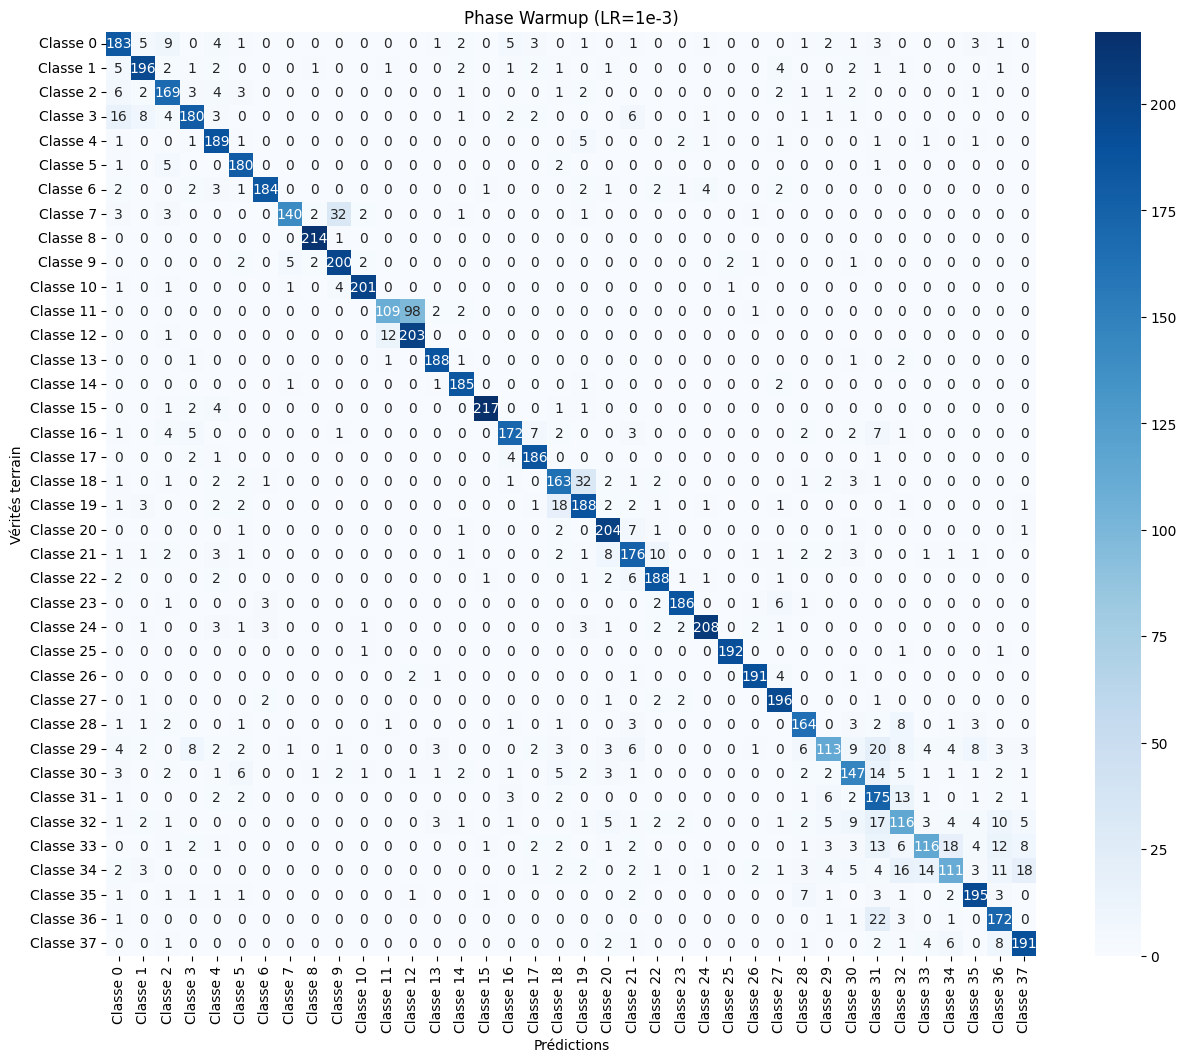


=== Rapport de classification - Phase Warmup (LR=1e-3) ===
              precision    recall  f1-score   support

    Classe 0       0.77      0.81      0.79       227
    Classe 1       0.87      0.88      0.87       224
    Classe 2       0.80      0.85      0.83       198
    Classe 3       0.87      0.80      0.83       226
    Classe 4       0.83      0.93      0.87       204
    Classe 5       0.87      0.95      0.91       189
    Classe 6       0.95      0.90      0.92       205
    Classe 7       0.95      0.76      0.84       185
    Classe 8       0.97      1.00      0.98       215
    Classe 9       0.83      0.93      0.88       215
   Classe 10       0.97      0.96      0.96       209
   Classe 11       0.88      0.51      0.65       212
   Classe 12       0.67      0.94      0.78       216
   Classe 13       0.94      0.97      0.95       194
   Classe 14       0.93      0.97      0.95       190
   Classe 15       0.98      0.96      0.97       226
   Classe 16       0.

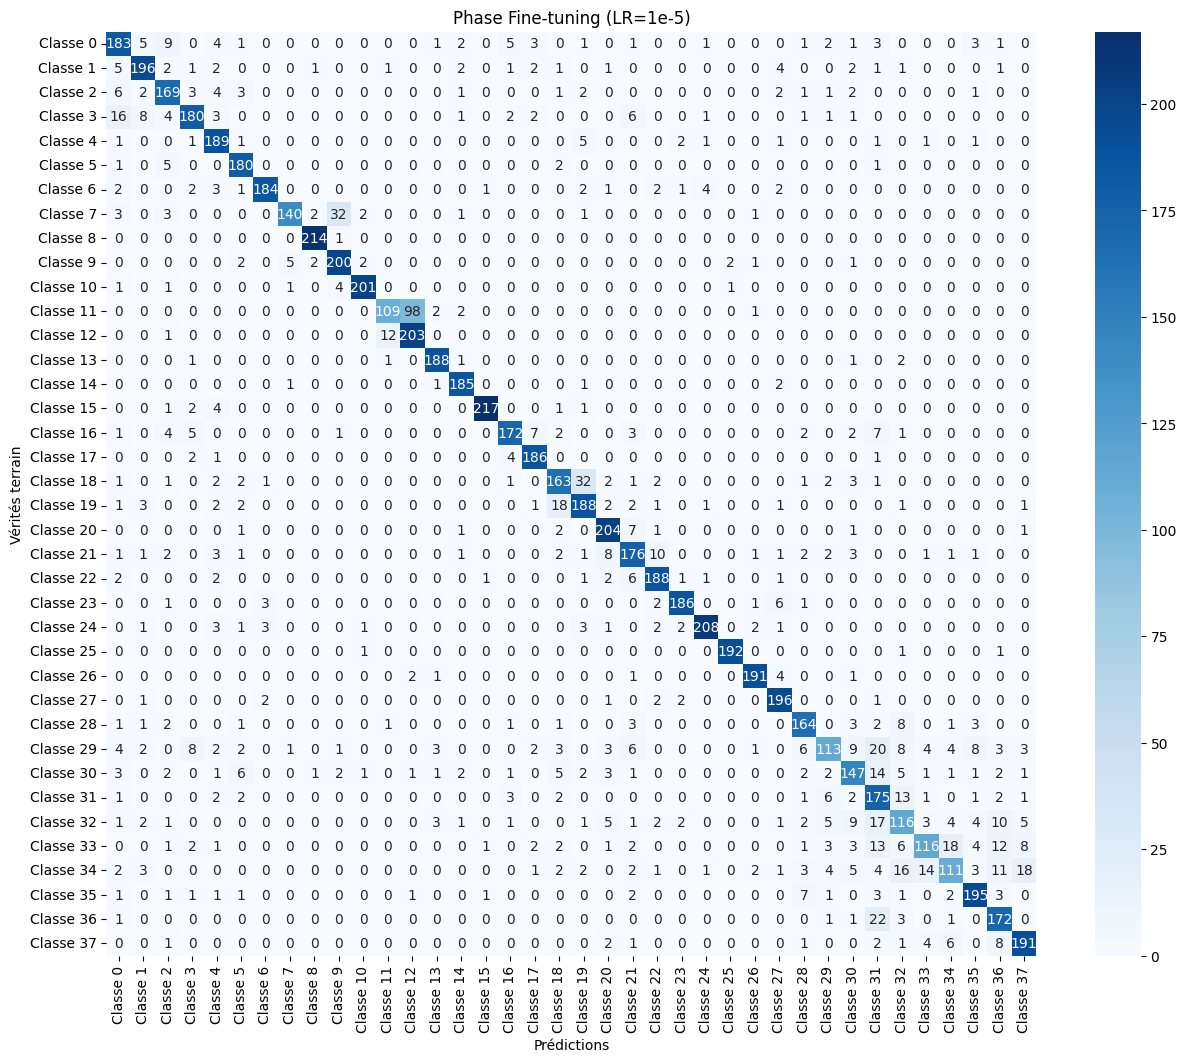


=== Rapport de classification - Phase Fine-tuning (LR=1e-5) ===
              precision    recall  f1-score   support

    Classe 0       0.77      0.81      0.79       227
    Classe 1       0.87      0.88      0.87       224
    Classe 2       0.80      0.85      0.83       198
    Classe 3       0.87      0.80      0.83       226
    Classe 4       0.83      0.93      0.87       204
    Classe 5       0.87      0.95      0.91       189
    Classe 6       0.95      0.90      0.92       205
    Classe 7       0.95      0.76      0.84       185
    Classe 8       0.97      1.00      0.98       215
    Classe 9       0.83      0.93      0.88       215
   Classe 10       0.97      0.96      0.96       209
   Classe 11       0.88      0.51      0.65       212
   Classe 12       0.67      0.94      0.78       216
   Classe 13       0.94      0.97      0.95       194
   Classe 14       0.93      0.97      0.95       190
   Classe 15       0.98      0.96      0.97       226
   Classe 16    

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, dataset, title="Matrice de confusion"):
    """
    Trace la matrice de confusion avec valeurs numériques et noms de classes.
    
    Args:
        model: modèle Keras
        dataset: tf.data.Dataset (inputs, labels)
        title: titre du graphique
    """
    
    y_true_list = []
    y_pred_list = []

    # ⚡ Accumuler labels et prédictions batch par batch
    for x_batch, y_batch in dataset:
        y_true_list.append(y_batch.numpy())
        y_pred_probs = model.predict(x_batch, verbose=0)
        y_pred_batch = np.argmax(y_pred_probs, axis=1)
        y_pred_list.append(y_pred_batch)

    # Convertir en arrays
    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    # Déterminer automatiquement les classes
    classes = np.unique(y_true)
    class_names = [f"Classe {i}" for i in classes]

    # Matrice de confusion (valeurs entières)
    cm = confusion_matrix(y_true, y_pred)

    # 🔹 Affichage avec valeurs et noms de classes
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités terrain')
    plt.title(f"{title}")
    plt.show()

    # Rapport détaillé
    print(f"\n=== Rapport de classification - {title} ===")
    print(classification_report(y_true, y_pred, target_names=class_names))
# ⚡ Matrice après Warmup
plot_confusion_matrix(mobilenet_model, val_ds_new, "Phase Warmup (LR=1e-3)")

# ⚡ Matrice après Fine-tuning
plot_confusion_matrix(mobilenet_model, val_ds_new, "Phase Fine-tuning (LR=1e-5)")


y_true.shape = (7909,), y_pred_probs.shape = (7909, 38)

=== Phase Warmup (LR=1e-3) ===
ROC-AUC Macro: 0.9955
ROC-AUC Micro: 0.9966


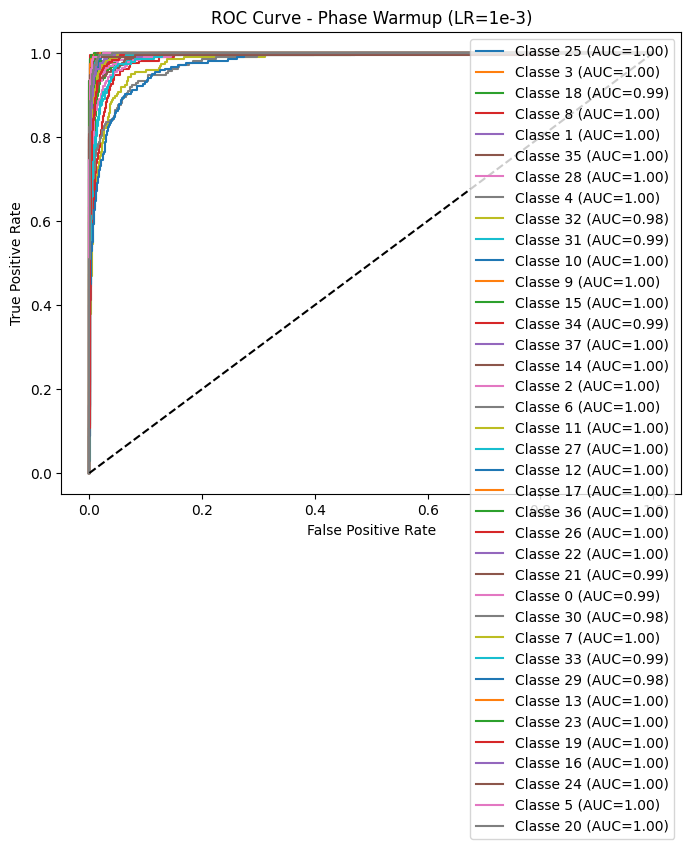

y_true.shape = (7909,), y_pred_probs.shape = (7909, 38)

=== Phase Fine-tuning (LR=1e-5) ===
ROC-AUC Macro: 0.9955
ROC-AUC Micro: 0.9966


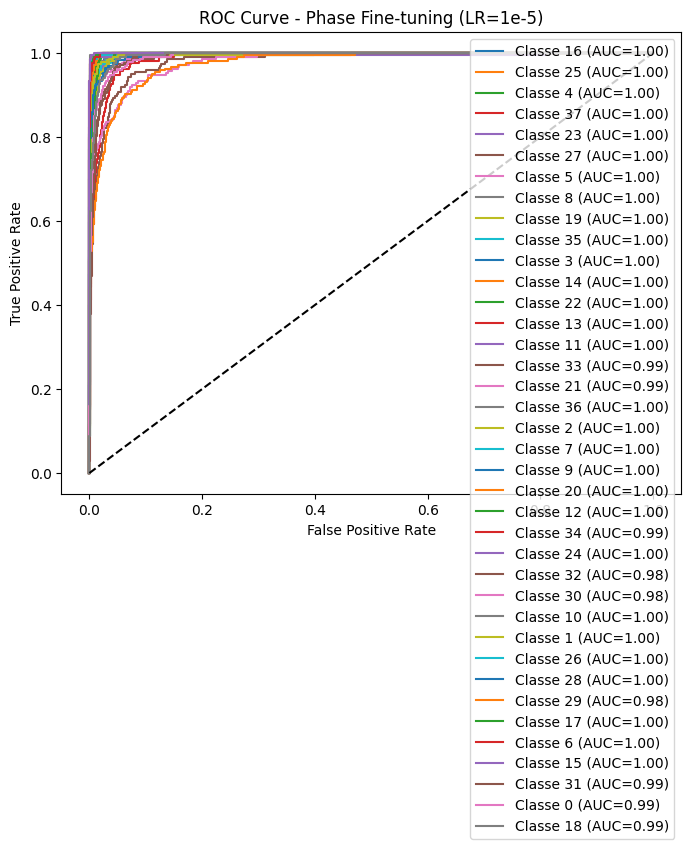

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_auc(model, dataset, n_classes, title="ROC-AUC"):
    """
    Affiche le ROC-AUC pour un dataset TensorFlow en mode multi-classes.
    
    Args:
        model: modèle Keras
        dataset: tf.data.Dataset (inputs, labels)
        n_classes: nombre de classes
        title: titre du graphique
    """
    
    y_true_list = []
    y_pred_list = []

    # ⚡ Accumuler les labels et les prédictions batch par batch
    for x_batch, y_batch in dataset:
        y_true_list.append(y_batch.numpy())
        y_pred_batch = model.predict(x_batch, verbose=0)
        y_pred_list.append(y_pred_batch)

    # Convertir en arrays
    y_true = np.concatenate(y_true_list, axis=0)
    y_pred_probs = np.concatenate(y_pred_list, axis=0)

    # Vérifier les shapes pour éviter l'erreur
    print(f"y_true.shape = {y_true.shape}, y_pred_probs.shape = {y_pred_probs.shape}")

    # Binariser les labels pour le ROC-AUC multi-classes
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    # Calcul du ROC-AUC
    roc_auc_macro = roc_auc_score(y_true_bin, y_pred_probs, average="macro", multi_class="ovr")
    roc_auc_micro = roc_auc_score(y_true_bin, y_pred_probs, average="micro", multi_class="ovr")

    print(f"\n=== {title} ===")
    print(f"ROC-AUC Macro: {roc_auc_macro:.4f}")
    print(f"ROC-AUC Micro: {roc_auc_micro:.4f}")

    # Tracer 3 courbes ROC aléatoires
    plt.figure(figsize=(8, 6))
    for i in np.random.choice(range(n_classes), size=max(3, n_classes), replace=False):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f"Classe {i} (AUC={auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {title}")
    plt.legend()
    plt.show()
# Définir correctement le nombre de classes
n_classes = 38  # Remplace 38 par ton nombre réel de classes si nécessaire

# ⚡ ROC-AUC après Warmup
plot_roc_auc(mobilenet_model, val_ds_new, n_classes, "Phase Warmup (LR=1e-3)")

# ⚡ ROC-AUC après Fine-tuning
plot_roc_auc(mobilenet_model, val_ds_new, n_classes, "Phase Fine-tuning (LR=1e-5)")


# test MobileNet


📊 Test — Acc:0.8456  Prec:0.8495  Rec:0.8456  F1:0.8427

              precision    recall  f1-score   support

    Classe 0       0.77      0.81      0.79       227
    Classe 1       0.87      0.88      0.87       224
    Classe 2       0.80      0.85      0.83       198
    Classe 3       0.87      0.80      0.83       226
    Classe 4       0.83      0.93      0.87       204
    Classe 5       0.87      0.95      0.91       189
    Classe 6       0.95      0.90      0.92       205
    Classe 7       0.95      0.76      0.84       185
    Classe 8       0.97      1.00      0.98       215
    Classe 9       0.83      0.93      0.88       215
   Classe 10       0.97      0.96      0.96       209
   Classe 11       0.88      0.51      0.65       212
   Classe 12       0.67      0.94      0.78       216
   Classe 13       0.94      0.97      0.95       194
   Classe 14       0.93      0.97      0.95       190
   Classe 15       0.98      0.96      0.97       226
   Classe 16       0.90

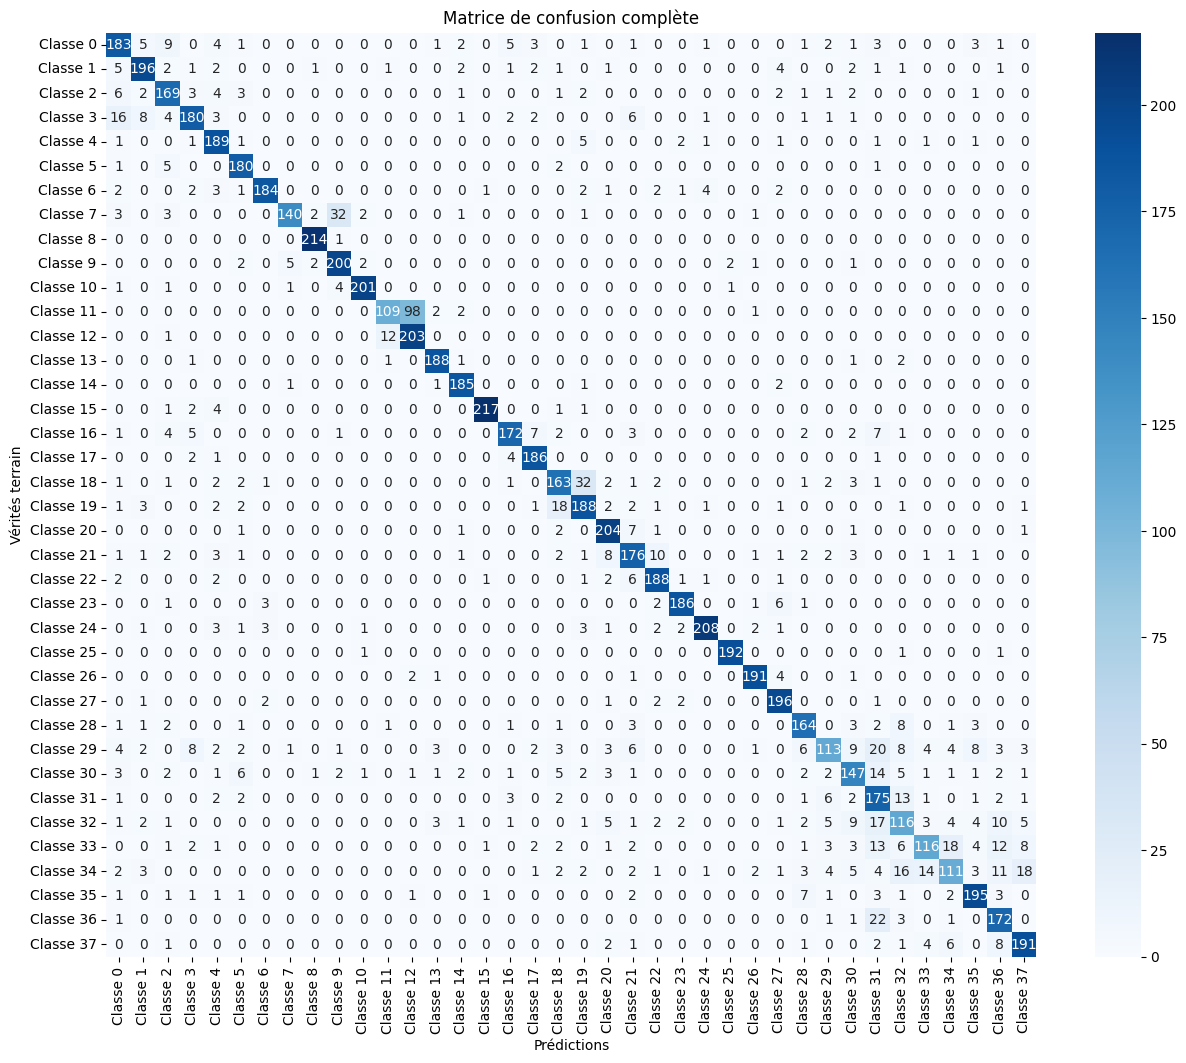

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Accumuler les vrais labels et les prédictions
y_true_list = []
y_pred_list = []

for x_batch, y_batch in val_ds_new:
    y_true_list.append(y_batch.numpy())
    y_pred_batch = np.argmax(mobilenet_model.predict(x_batch, verbose=0), axis=1)
    y_pred_list.append(y_pred_batch)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calcul des métriques globales
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\n📊 Test — Acc:{acc:.4f}  Prec:{prec:.4f}  Rec:{rec:.4f}  F1:{f1:.4f}\n")

# Générer automatiquement les noms de classes pour éviter le mismatch
classes = np.unique(y_true)
class_names = [f"Classe {i}" for i in classes]

# Rapport détaillé
print(classification_report(y_true, y_pred, labels=classes, target_names=class_names, zero_division=0))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=classes)

# 🔹 Affichage
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.title('Matrice de confusion complète')
plt.show()


In [70]:
import numpy as np
import pandas as pd

# Nombre de classes
n_classes = len(class_names)  

class_samples = {}
X_test_aug = []
true_labels_idx = []
true_labels_name = []

# -----------------------------
# 1️⃣ Sélectionner 1 image par classe depuis val_ds_new
# -----------------------------
for batch in val_ds_new:
    images, labels = batch
    labels_idx = labels.numpy() if len(labels.shape) == 1 else np.argmax(labels.numpy(), axis=1)

    for i, label in enumerate(labels_idx):
        if label not in class_samples:  # première image trouvée pour cette classe
            class_samples[label] = True
            X_test_aug.append(images[i].numpy())
            true_labels_idx.append(label)              # indice réel
            true_labels_name.append(class_names[label]) # nom réel
    if len(class_samples) == n_classes:
        break
X_test_aug = np.stack(X_test_aug, axis=0)
print("Images test simulées :", X_test_aug.shape)

# -----------------------------
# 2️⃣ Faire les prédictions
# -----------------------------
y_pred_proba = model.predict(X_test_aug, verbose=0)
pred_classes_idx = np.argmax(y_pred_proba, axis=1)
pred_classes_name = [class_names[i] for i in pred_classes_idx]

# -----------------------------
# 3️⃣ Créer le DataFrame final
# -----------------------------
df_pred = pd.DataFrame({
    "true_class_idx": true_labels_idx,
    "true_class": true_labels_name,
    "predicted_class_idx": pred_classes_idx,
    "predicted_class": pred_classes_name
})

# Sauvegarde CSV
output_csv = "predictions_test_simulated.csv"
df_pred.to_csv(output_csv, index=False)

print(f"CSV final généré : {output_csv}")
print(df_pred.head(38).to_markdown(index=False))


Images test simulées : (38, 224, 224, 3)
CSV final généré : predictions_test_simulated.csv
|   true_class_idx | true_class   |   predicted_class_idx | predicted_class   |
|-----------------:|:-------------|----------------------:|:------------------|
|               15 | Classe 15    |                    15 | Classe 15         |
|               28 | Classe 28    |                    28 | Classe 28         |
|               21 | Classe 21    |                    21 | Classe 21         |
|               18 | Classe 18    |                    18 | Classe 18         |
|               13 | Classe 13    |                    13 | Classe 13         |
|               22 | Classe 22    |                    22 | Classe 22         |
|               35 | Classe 35    |                    35 | Classe 35         |
|               16 | Classe 16    |                    16 | Classe 16         |
|                7 | Classe 7     |                     7 | Classe 7          |
|               34 | Classe 3